In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.stats import entropy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Kaiti', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300

# Load data

In [ ]:
df = pd.read_csv('zomato.csv')
print(df.columns)
print(f"Data Overview:")
print(f"- Total Number of Restaurants: {len(df)}")
print(f"- Coverage Areas (Unique Localities): {df['Locality'].nunique()}")
print(f"- Number of Cuisine Types: {df['Cuisines'].str.split(',').explode().nunique()}")


Index(['Unnamed: 0', 'Restaurant ID', 'Restaurant Name', 'Country Code',
       'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude',
       'Latitude', 'Cuisines', 'Average Cost for two', 'Currency',
       'Has Table booking', 'Has Online delivery', 'Is delivering now',
       'Switch to order menu', 'Price range', 'Aggregate rating',
       'Rating color', 'Rating text', 'Votes', 'Country', 'Exchange Rate',
       'Converted Cost (INR)'],
      dtype='object')
Data Overview:
- Total Number of Restaurants: 19719
- Coverage Areas (Unique Localities): 1208
- Number of Cuisine Types: 145


# Research area

【Restaurant Distribution by Country】
          Country  Number of Restaurants  Percentage (%)
0           India                  17854       90.542117
1   United States                    893        4.528627
2    South Africa                    172        0.872255
3  United Kingdom                    150        0.760688
4             UAE                    136        0.689690


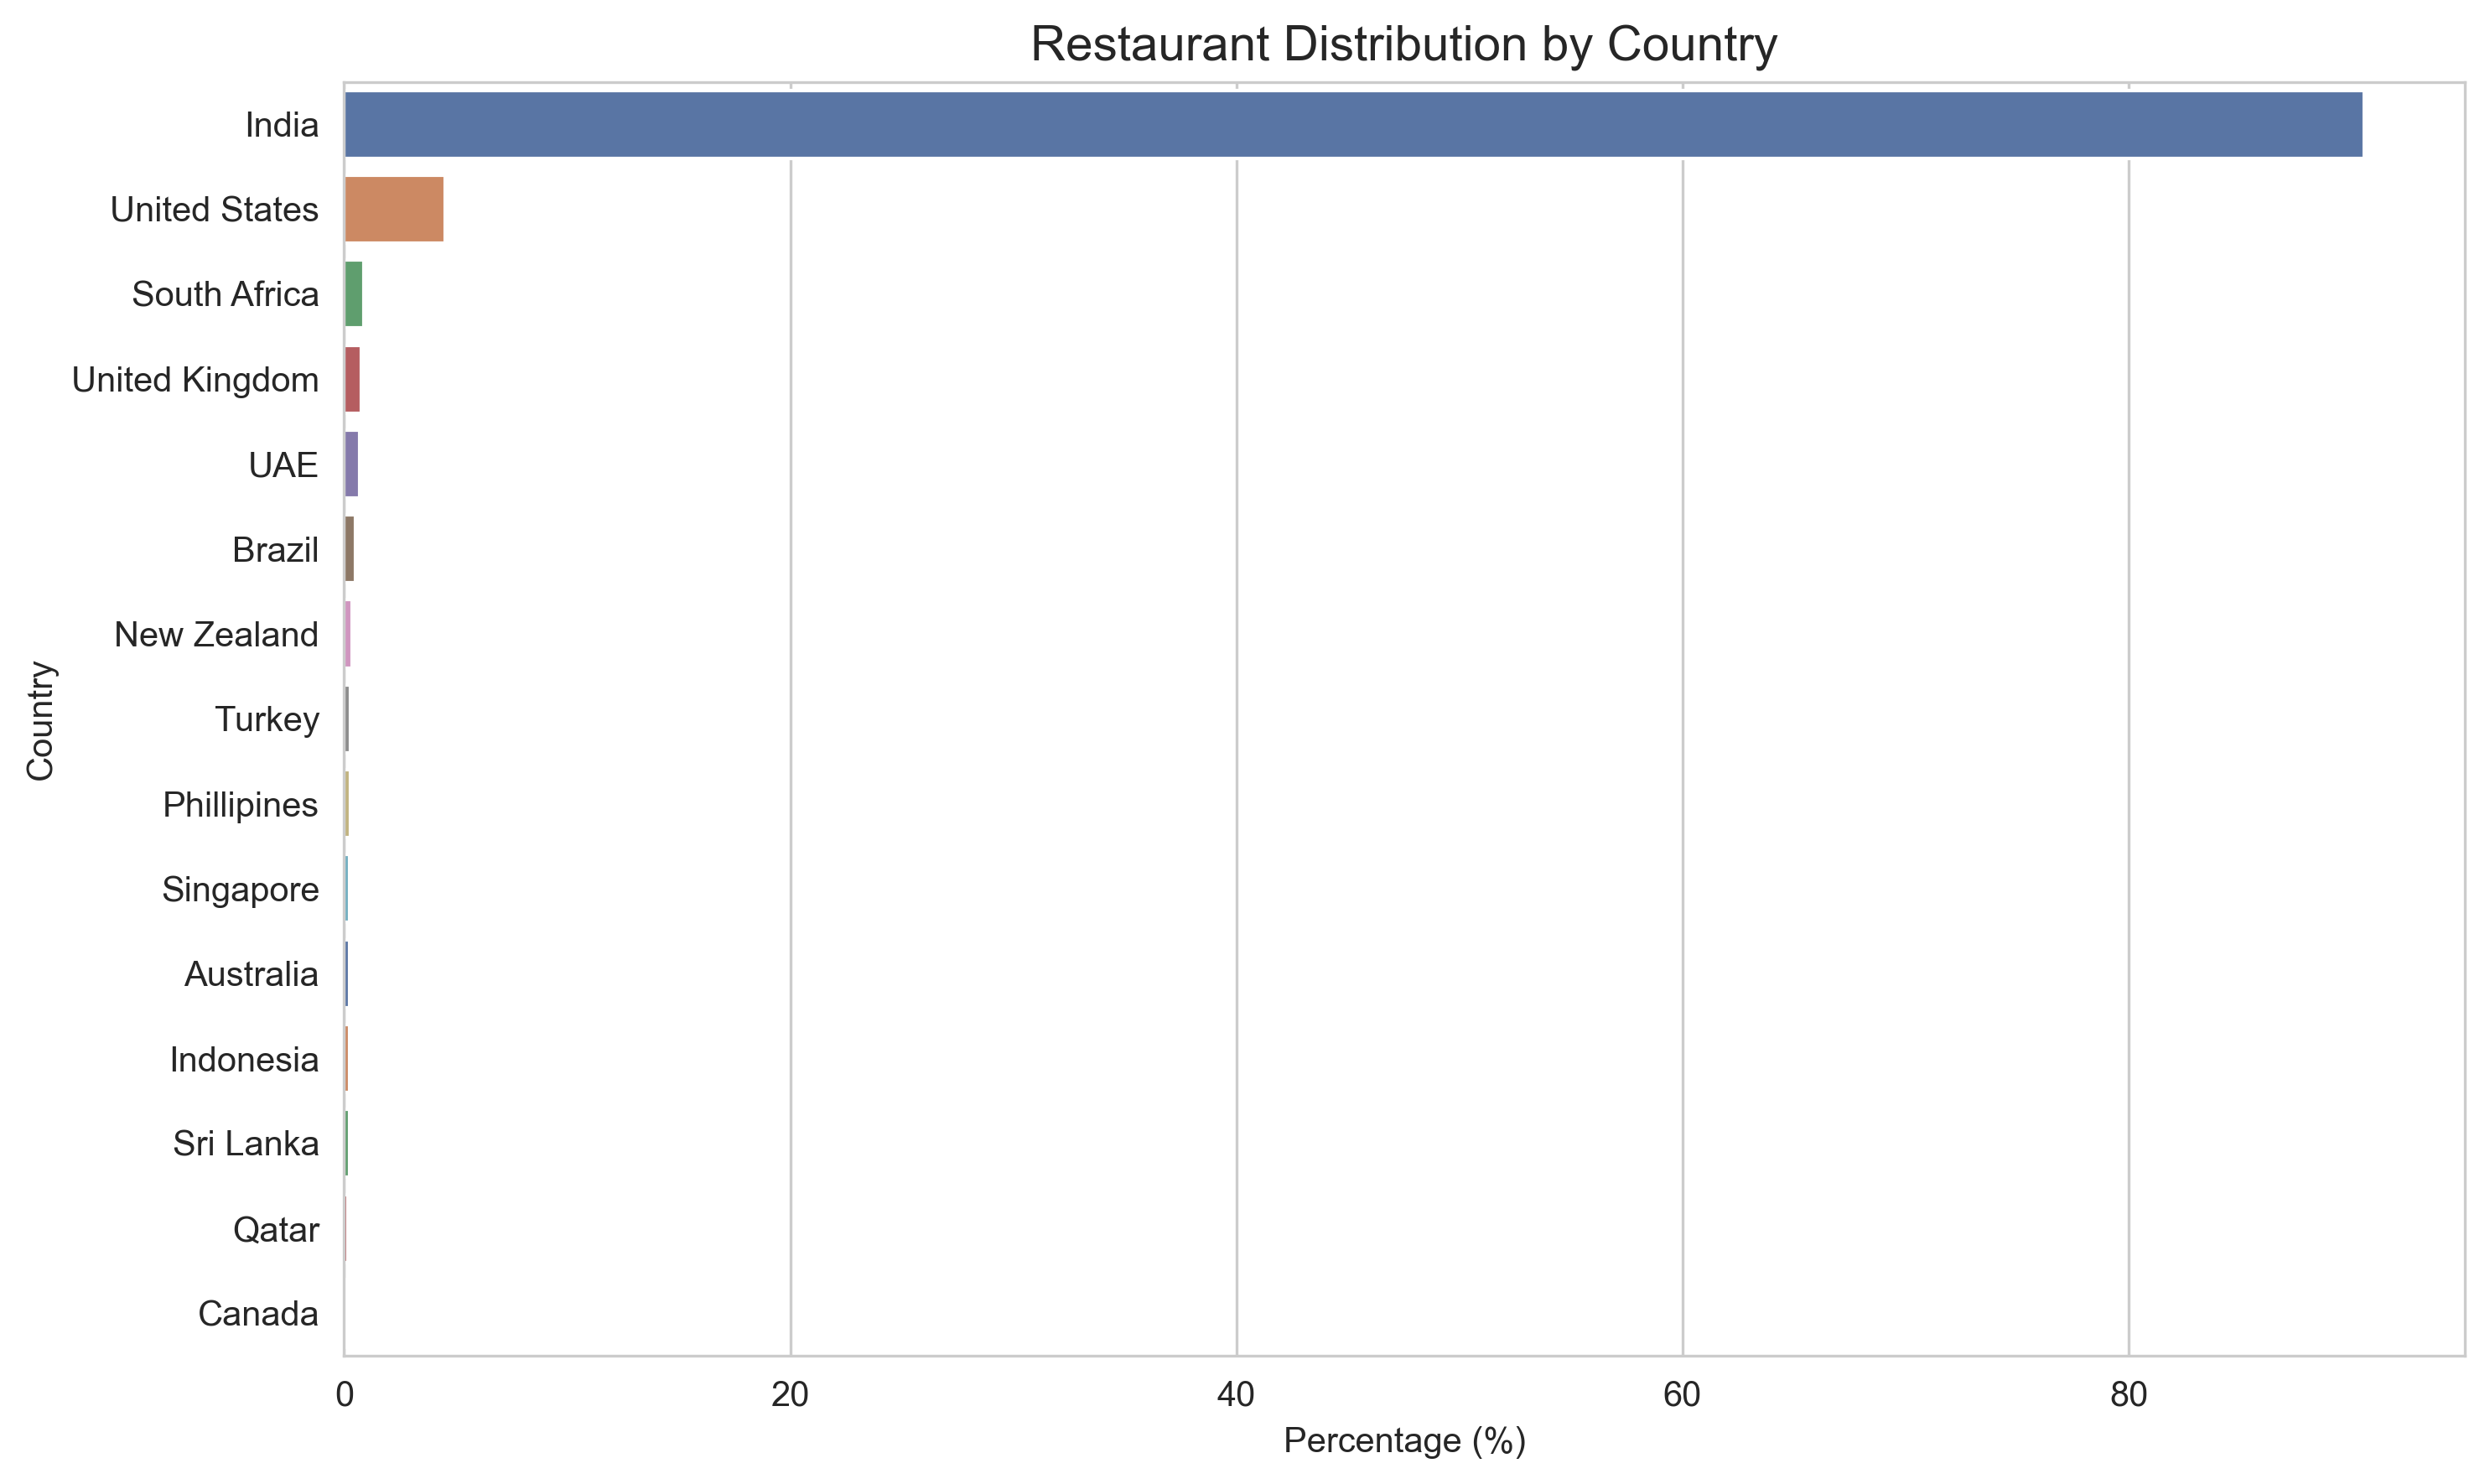

In [7]:
# --------------------------------------------
# 1. Restaurant distribution by country
# --------------------------------------------
country_counts = df['Country'].value_counts()
country_percent = (country_counts / country_counts.sum()) * 100

# Combine into a single DataFrame for display
country_df = pd.DataFrame({
    'Number of Restaurants': country_counts,
    'Percentage (%)': country_percent
}).reset_index().rename(columns={'index': 'Country'})

print("【Restaurant Distribution by Country】")
print(country_df.head())

# Top 10 countries
plt.figure(figsize=(10,6))
sns.barplot(data=country_df, x='Percentage (%)', y='Country', palette= 'deep')
plt.title("Restaurant Distribution by Country", fontsize=14)
plt.xlabel("Percentage (%)")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig('Restaurant Distribution by Country.png',dpi=500)
plt.show()



【Top Indian Cities by Number of Restaurants】
City
New Delhi    10888
Gurgaon       2393
Noida         2180
Faridabad      499
Ahmedabad       76
Mumbai          76
Jaipur          76
Chennai         62
Pune            60
Vizag           60
Kochi           58
Hyderabad       58
Goa             58
Bangalore       57
Guwahati        56
Name: count, dtype: int64


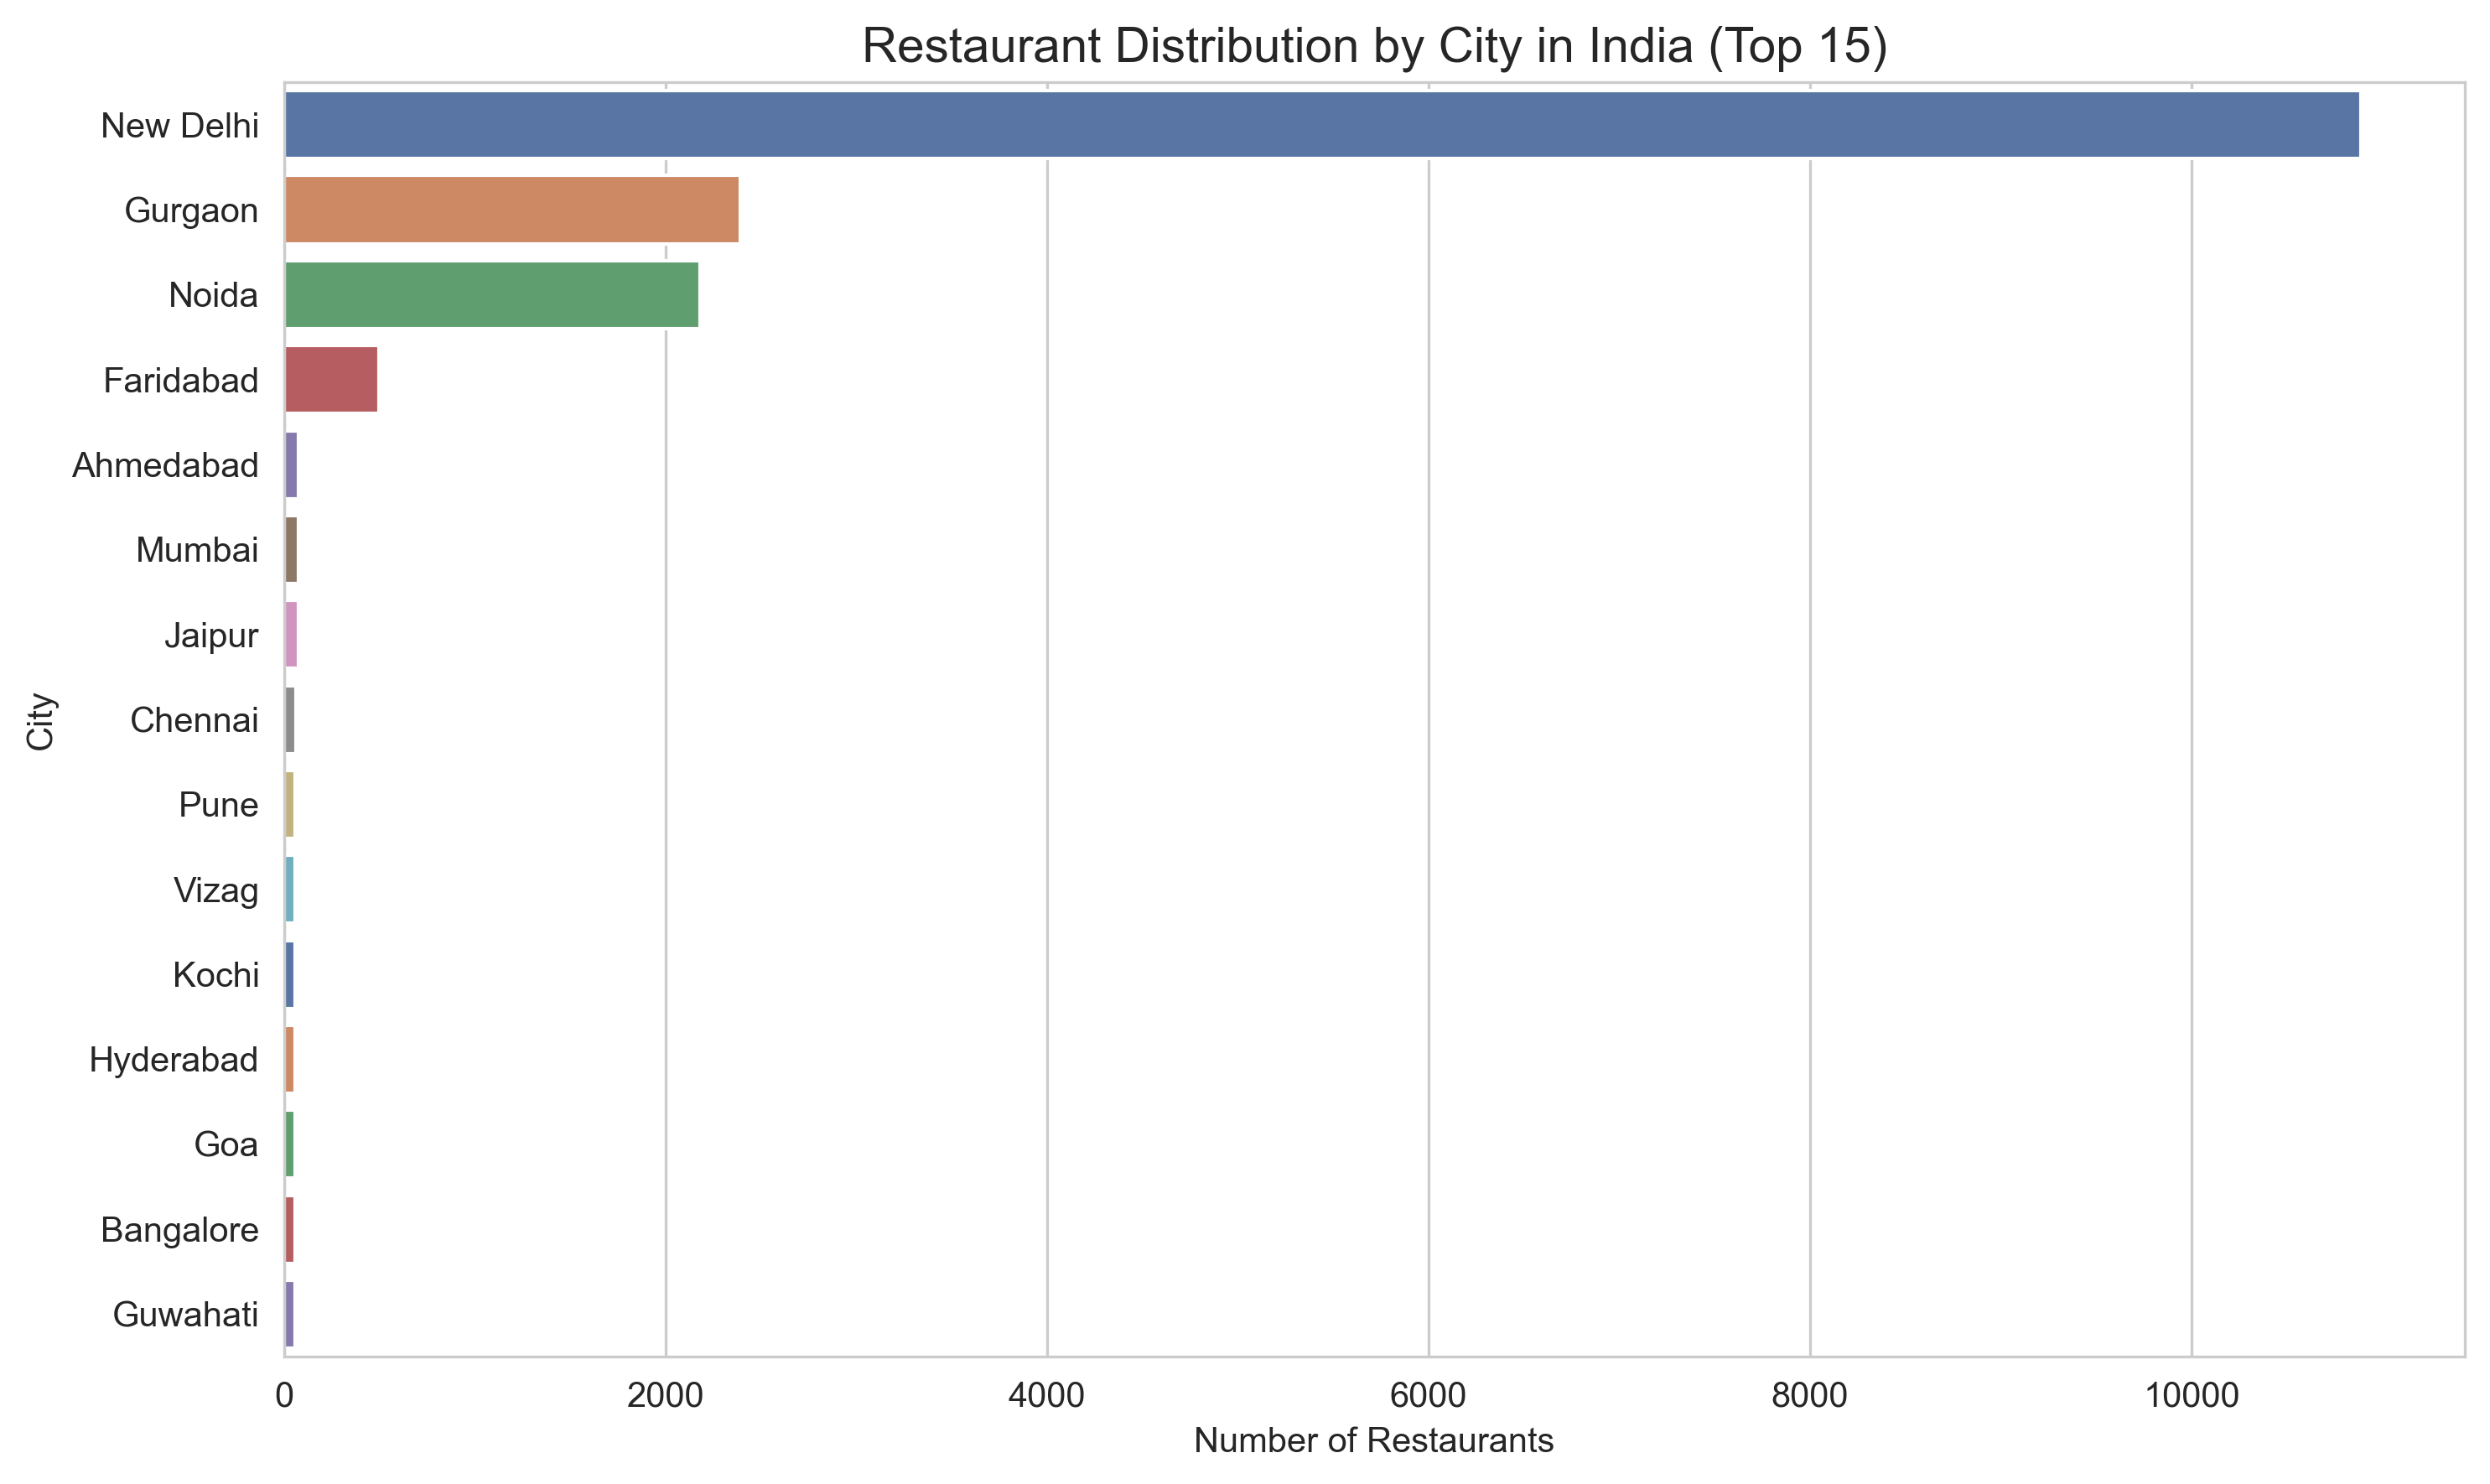

In [8]:
# --------------------------------------------
# 2. Restaurant distribution by city in India
# --------------------------------------------
india_df = df[df['Country'] == 'India']
city_counts = india_df['City'].value_counts().head(15)

print("\n【Top Indian Cities by Number of Restaurants】")
print(city_counts)

plt.figure(figsize=(10,6))
sns.barplot(x=city_counts.values, y=city_counts.index, palette='deep')
plt.title("Restaurant Distribution by City in India (Top 15)", fontsize=14)
plt.xlabel("Number of Restaurants")
plt.ylabel("City")
plt.tight_layout()
plt.savefig('Restaurant Distribution by City in India (Top 15).png',dpi=500)
plt.show()

In [9]:
# --------------------------------------------
# 3. Heatmap
# --------------------------------------------
import folium
from folium.plugins import HeatMap

# Filter for India data
india_df = df[df['Country'] == 'India']

# Remove missing coordinates
india_df = india_df.dropna(subset=['Latitude', 'Longitude'])

# Base map (centered on India)
m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles='CartoDB positron')

# Heatmap layer
heat_data = india_df[['Latitude', 'Longitude']].values.tolist()
HeatMap(heat_data, radius=10, blur=15).add_to(m)

# Save and display
m.save('india_restaurant_heatmap.html')
m

# Data Cleaning and Preprocessing

In [11]:
delhi_df = df[df['City'] == 'New Delhi']
print(f"- Total Number of Restaurants: {len(delhi_df)}")

- Total Number of Restaurants: 10888


In [12]:
# Check for missing values
print(delhi_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10888 entries, 5669 to 16556
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10888 non-null  int64  
 1   Restaurant ID         10888 non-null  int64  
 2   Restaurant Name       10888 non-null  object 
 3   Country Code          10888 non-null  int64  
 4   City                  10888 non-null  object 
 5   Address               10888 non-null  object 
 6   Locality              10888 non-null  object 
 7   Locality Verbose      10888 non-null  object 
 8   Longitude             10888 non-null  float64
 9   Latitude              10888 non-null  float64
 10  Cuisines              10888 non-null  object 
 11  Average Cost for two  10888 non-null  int64  
 12  Currency              10888 non-null  object 
 13  Has Table booking     10888 non-null  object 
 14  Has Online delivery   10888 non-null  object 
 15  Is delivering now    

In [13]:
# Remove invalid ratings or votes
delhi_df = delhi_df[(delhi_df['Aggregate rating'] > 0) & (delhi_df['Votes'] >= 0)]

In [14]:
print(f"- Total Number of Restaurants: {len(delhi_df)}")

# Simple descriptive statistics
print("Key Field Statistics:")
print(delhi_df[['Aggregate rating', 'Votes', 'Average Cost for two']].describe())

- Total Number of Restaurants: 8661
Key Field Statistics:
       Aggregate rating        Votes  Average Cost for two
count       8661.000000  8661.000000           8661.000000
mean           3.332456   196.979102            768.150329
std            0.478531   476.452761            712.565119
min            1.900000     4.000000             50.000000
25%            3.000000    18.000000            400.000000
50%            3.300000    56.000000            550.000000
75%            3.700000   160.000000            900.000000
max            4.900000  7931.000000           8000.000000


# EDA

## Checking online order or not

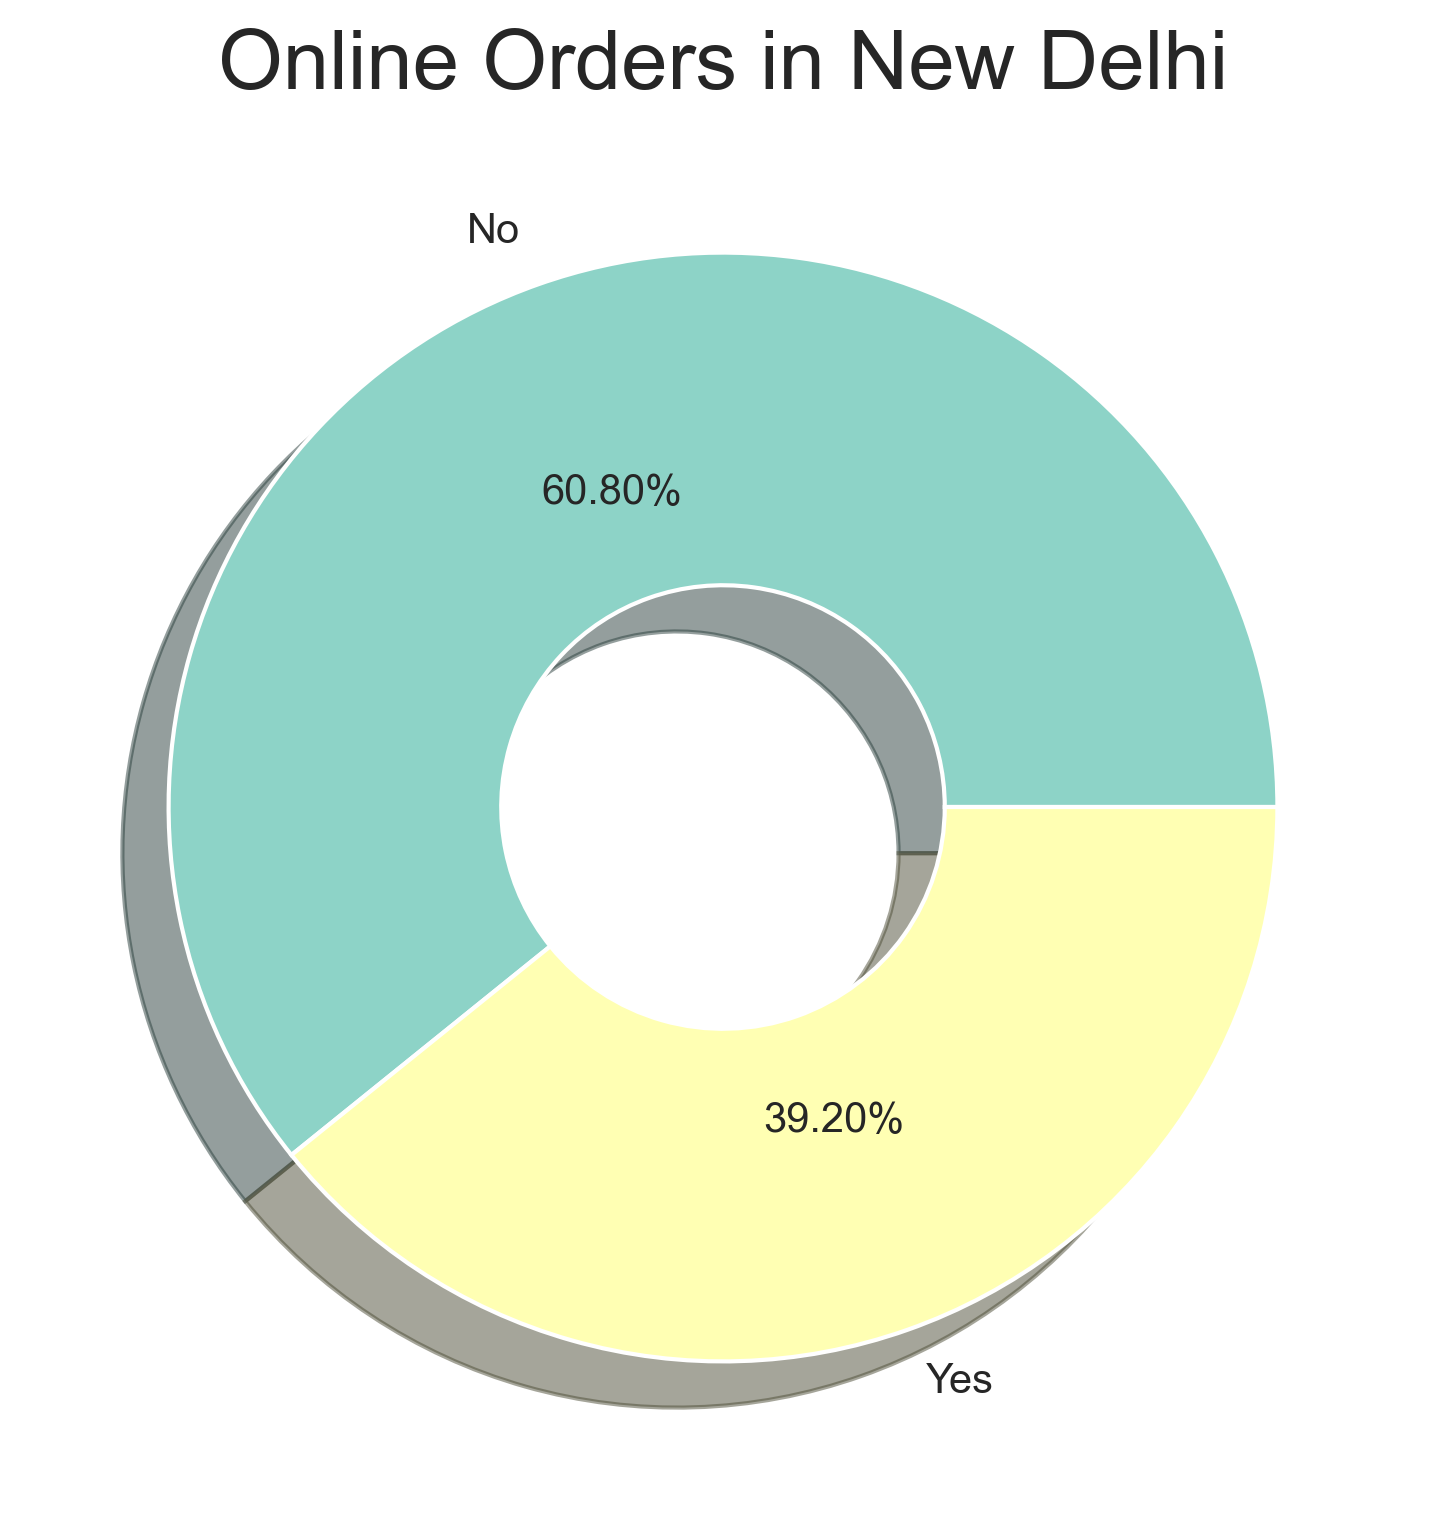

In [16]:
v_online = delhi_df['Has Online delivery'].value_counts()  

fig = plt.gcf()
fig.set_size_inches((10,6))
cmap = plt.get_cmap('Set3')
color = cmap(np.arange(len(v_online)))

plt.pie(v_online, labels=v_online.index, wedgeprops=dict(width=0.6),
        autopct='%0.2f%%', shadow=True, colors=color)
plt.title('Online Orders in New Delhi', fontsize=20)
plt.savefig('PNG/Online Orders in New Delhi.png',dpi=500)
plt.show()

## Book table or not

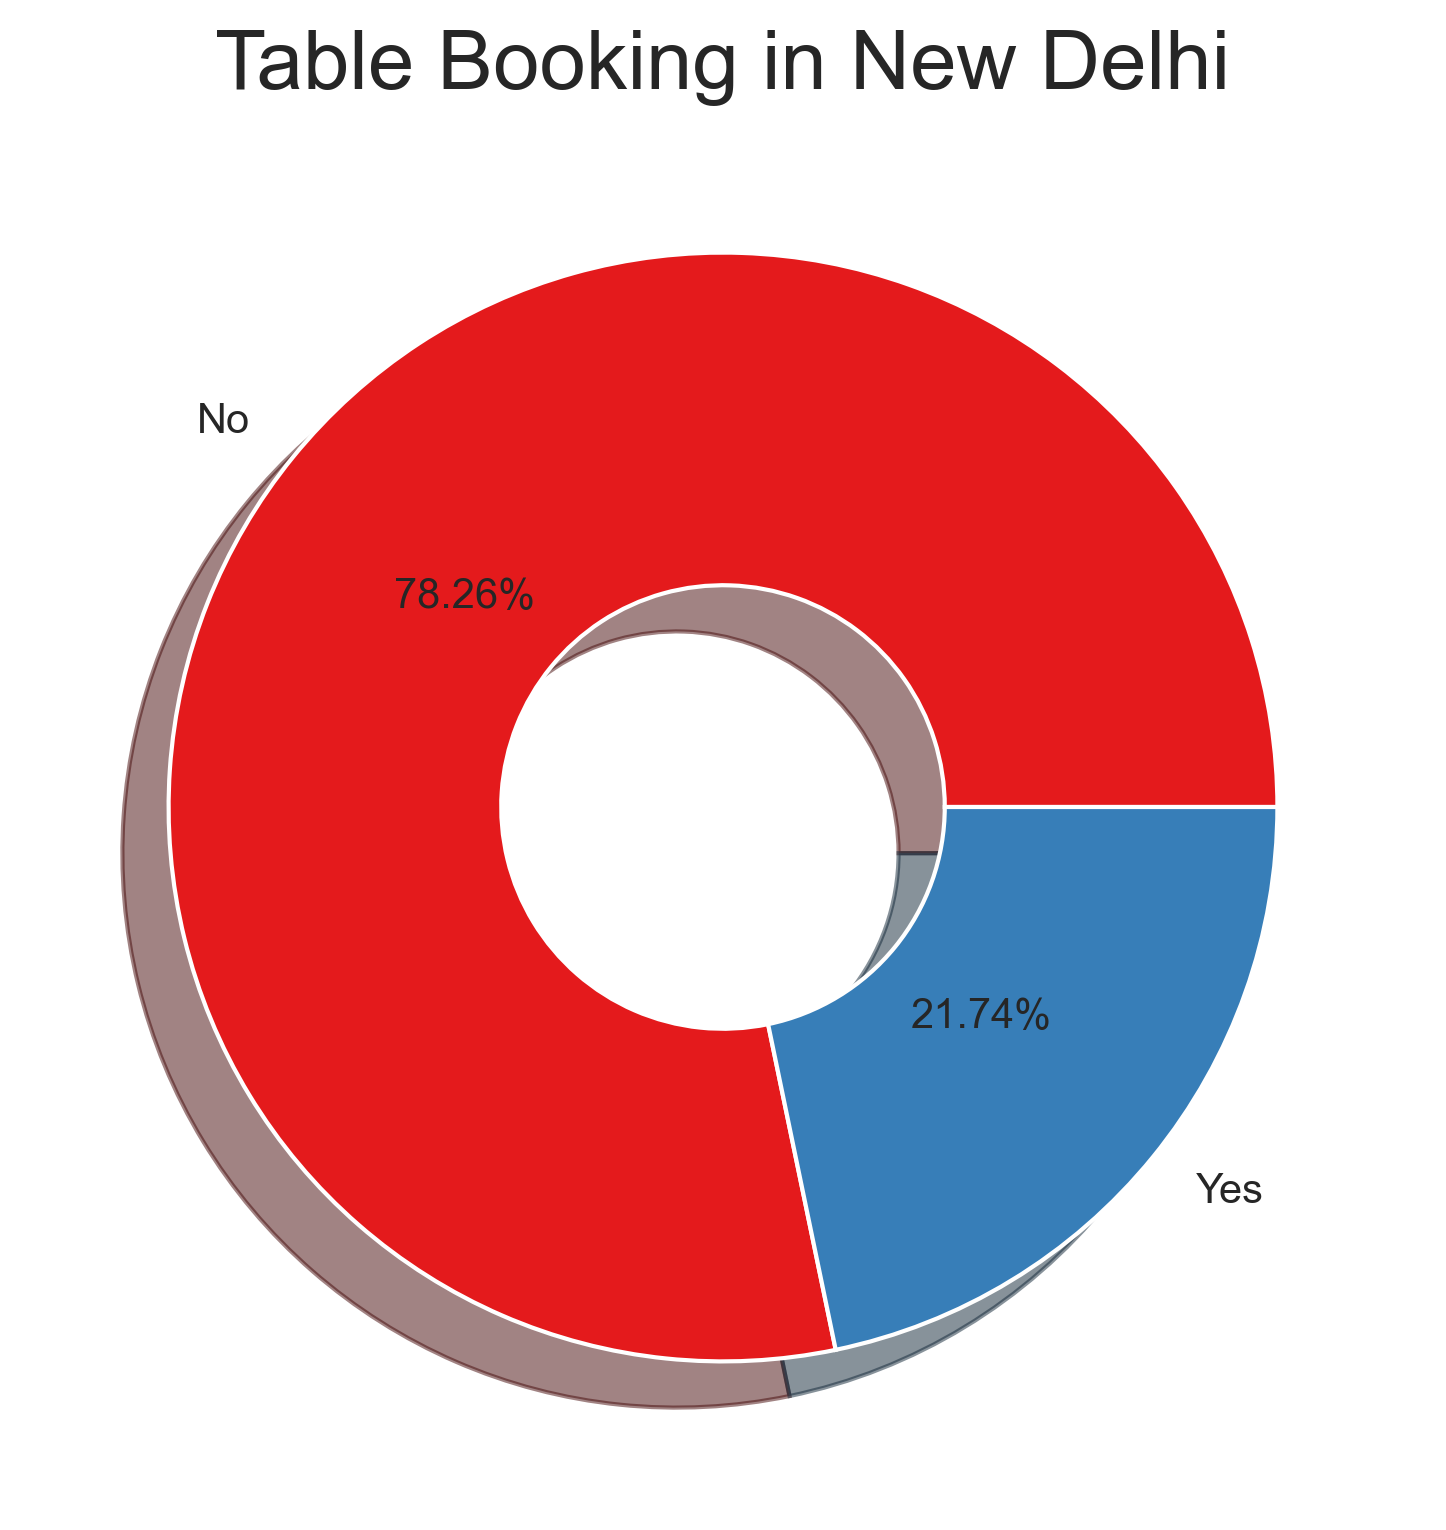

In [17]:
v_table = delhi_df['Has Table booking'].value_counts()  
fig = plt.gcf()
fig.set_size_inches((8,6))
cmap = plt.get_cmap('Set1')
color = cmap(np.arange(len(v_table)))

plt.pie(v_table, labels=v_table.index, wedgeprops=dict(width=0.6),
        autopct='%0.2f%%', shadow=True, colors=color)
plt.title('Table Booking in New Delhi', fontsize=20)
plt.savefig('PNG/Table Booking in New Delhi.png',dpi=500)
plt.show()

## Cost Distribution

              min   max
Price range            
1              50   450
2             500   950
3            1000  1950
4            2000  8000


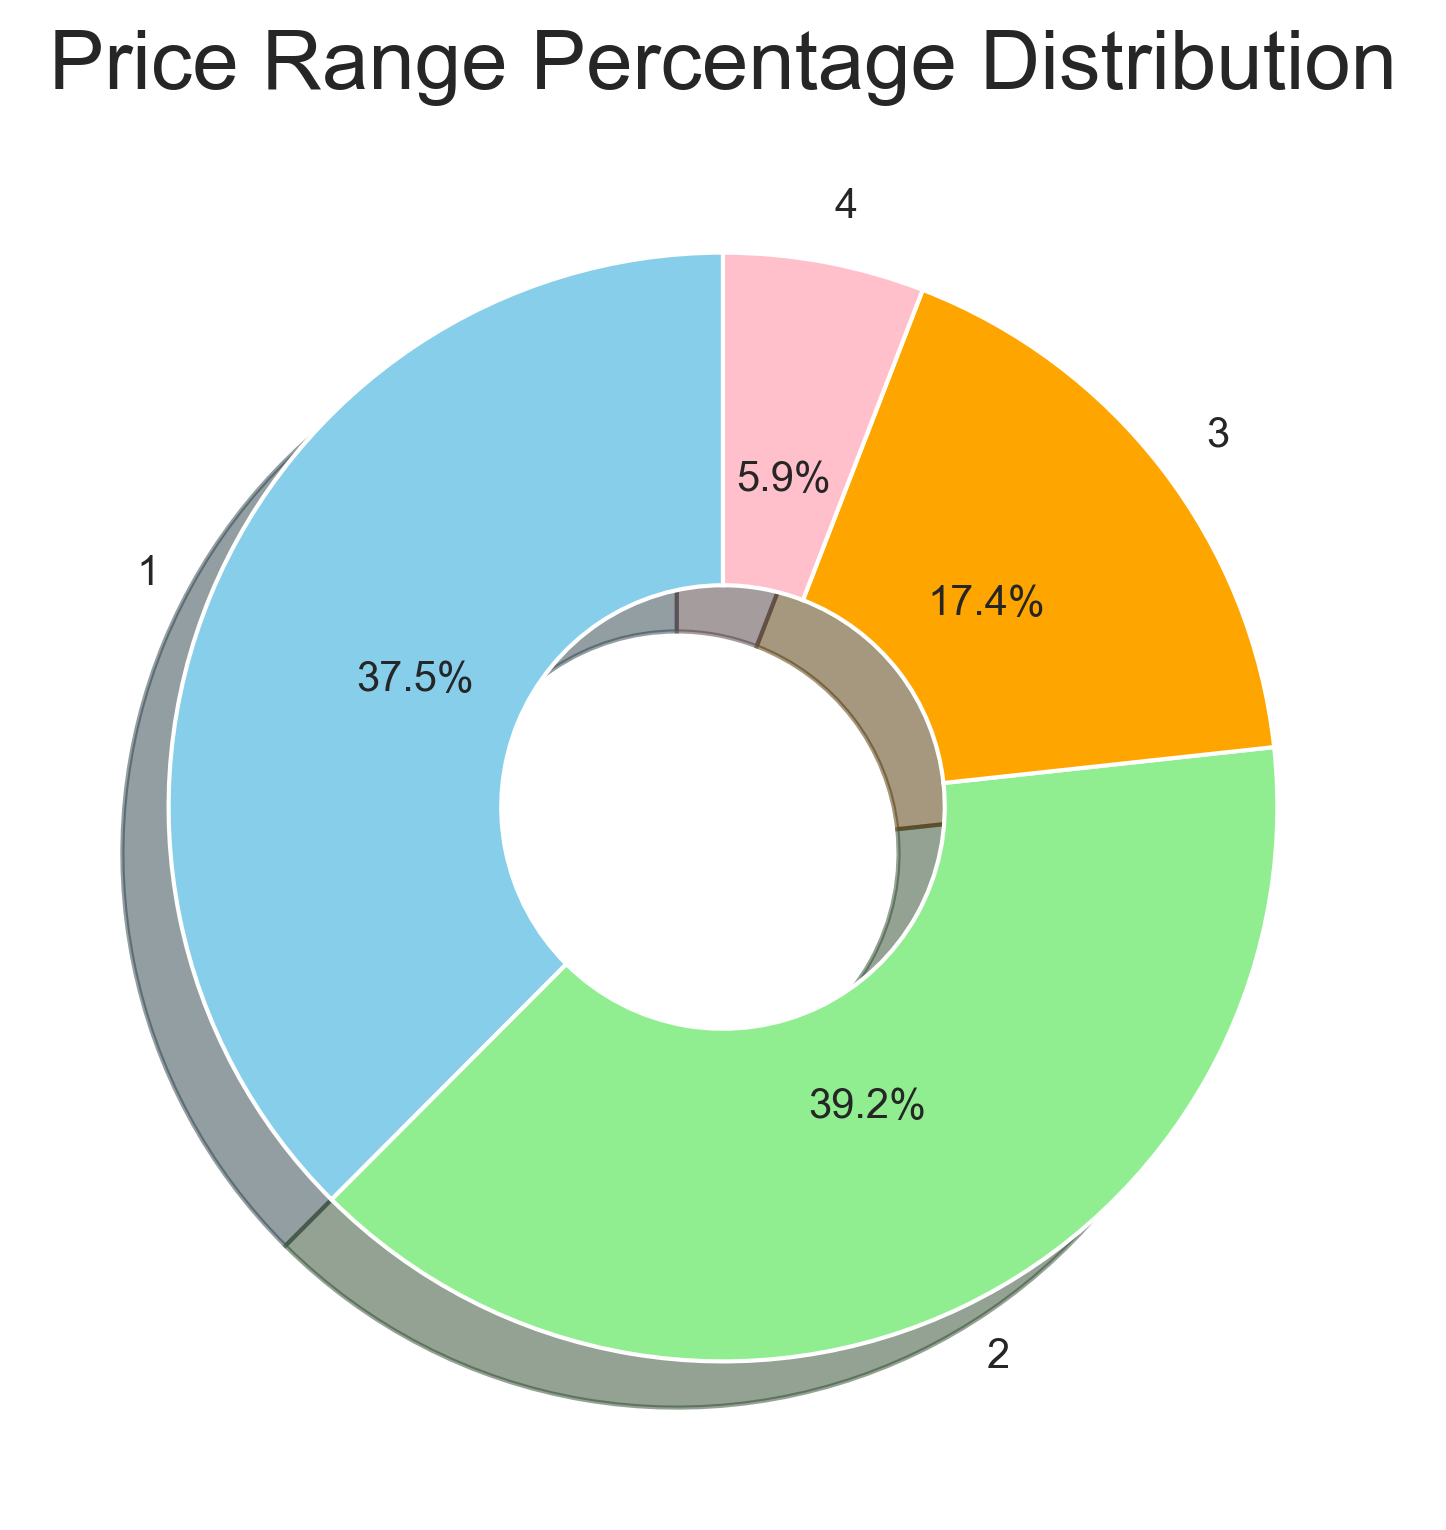

In [18]:
cost_range = delhi_df.groupby('Price range')['Average Cost for two'].agg(['min', 'max'])
print(cost_range)

price_counts = delhi_df['Price range'].value_counts().sort_index()
price_pct = price_counts / price_counts.sum() * 100

fig = plt.gcf()
fig.set_size_inches((8, 6))
plt.pie(price_pct, labels=price_pct.index, wedgeprops=dict(width=0.6),autopct='%1.1f%%', 
        startangle=90, shadow=True, colors=['skyblue','lightgreen','orange','pink'])
plt.title('Price Range Percentage Distribution', fontsize=20)
plt.savefig('PNG/Price Range Percentage Distribution.png',dpi=500)
plt.show()

## Most Popular Cuisines

In [ ]:
top_cuisines = delhi_df['Cuisines'].value_counts()[:15]
print(top_cuisines)
plt.figure(figsize=(8,6))
ax = sns.barplot(x=top_cuisines.index, y=top_cuisines.values, palette='Paired')

for i in ax.patches:
    ax.annotate(i.get_height().astype(int), (i.get_x() + i.get_width()/2, i.get_height()),
                ha='center', va='bottom')

plt.title('Top 15 Cuisines in New Delhi', fontsize=20)
plt.xlabel('Cuisines', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('PNG/Top 15 Cuisines in New Delhi.png',dpi=500)
plt.show()

## Top Restaurants by Votes

Restaurant Name
Big Chill                 43412
Hauz Khas Social          31724
Warehouse Cafe            24570
Ricos                     24510
Out Of The Box            23209
Big Yellow Door           22533
Haldiram's                20346
Subway                    17052
QD's Restaurant           14144
Wood Box Cafe             13796
The Vault Cafe            13652
The Flying Saucer Cafe    12580
Karim's                   12168
Bikanervala               11400
Imperfecto                11235
Barbeque Nation           11202
Wenger's                  10773
Dunkin' Donuts            10671
Rajinder Da Dhaba         10590
Lord of the Drinks        10356
Name: Votes, dtype: int64


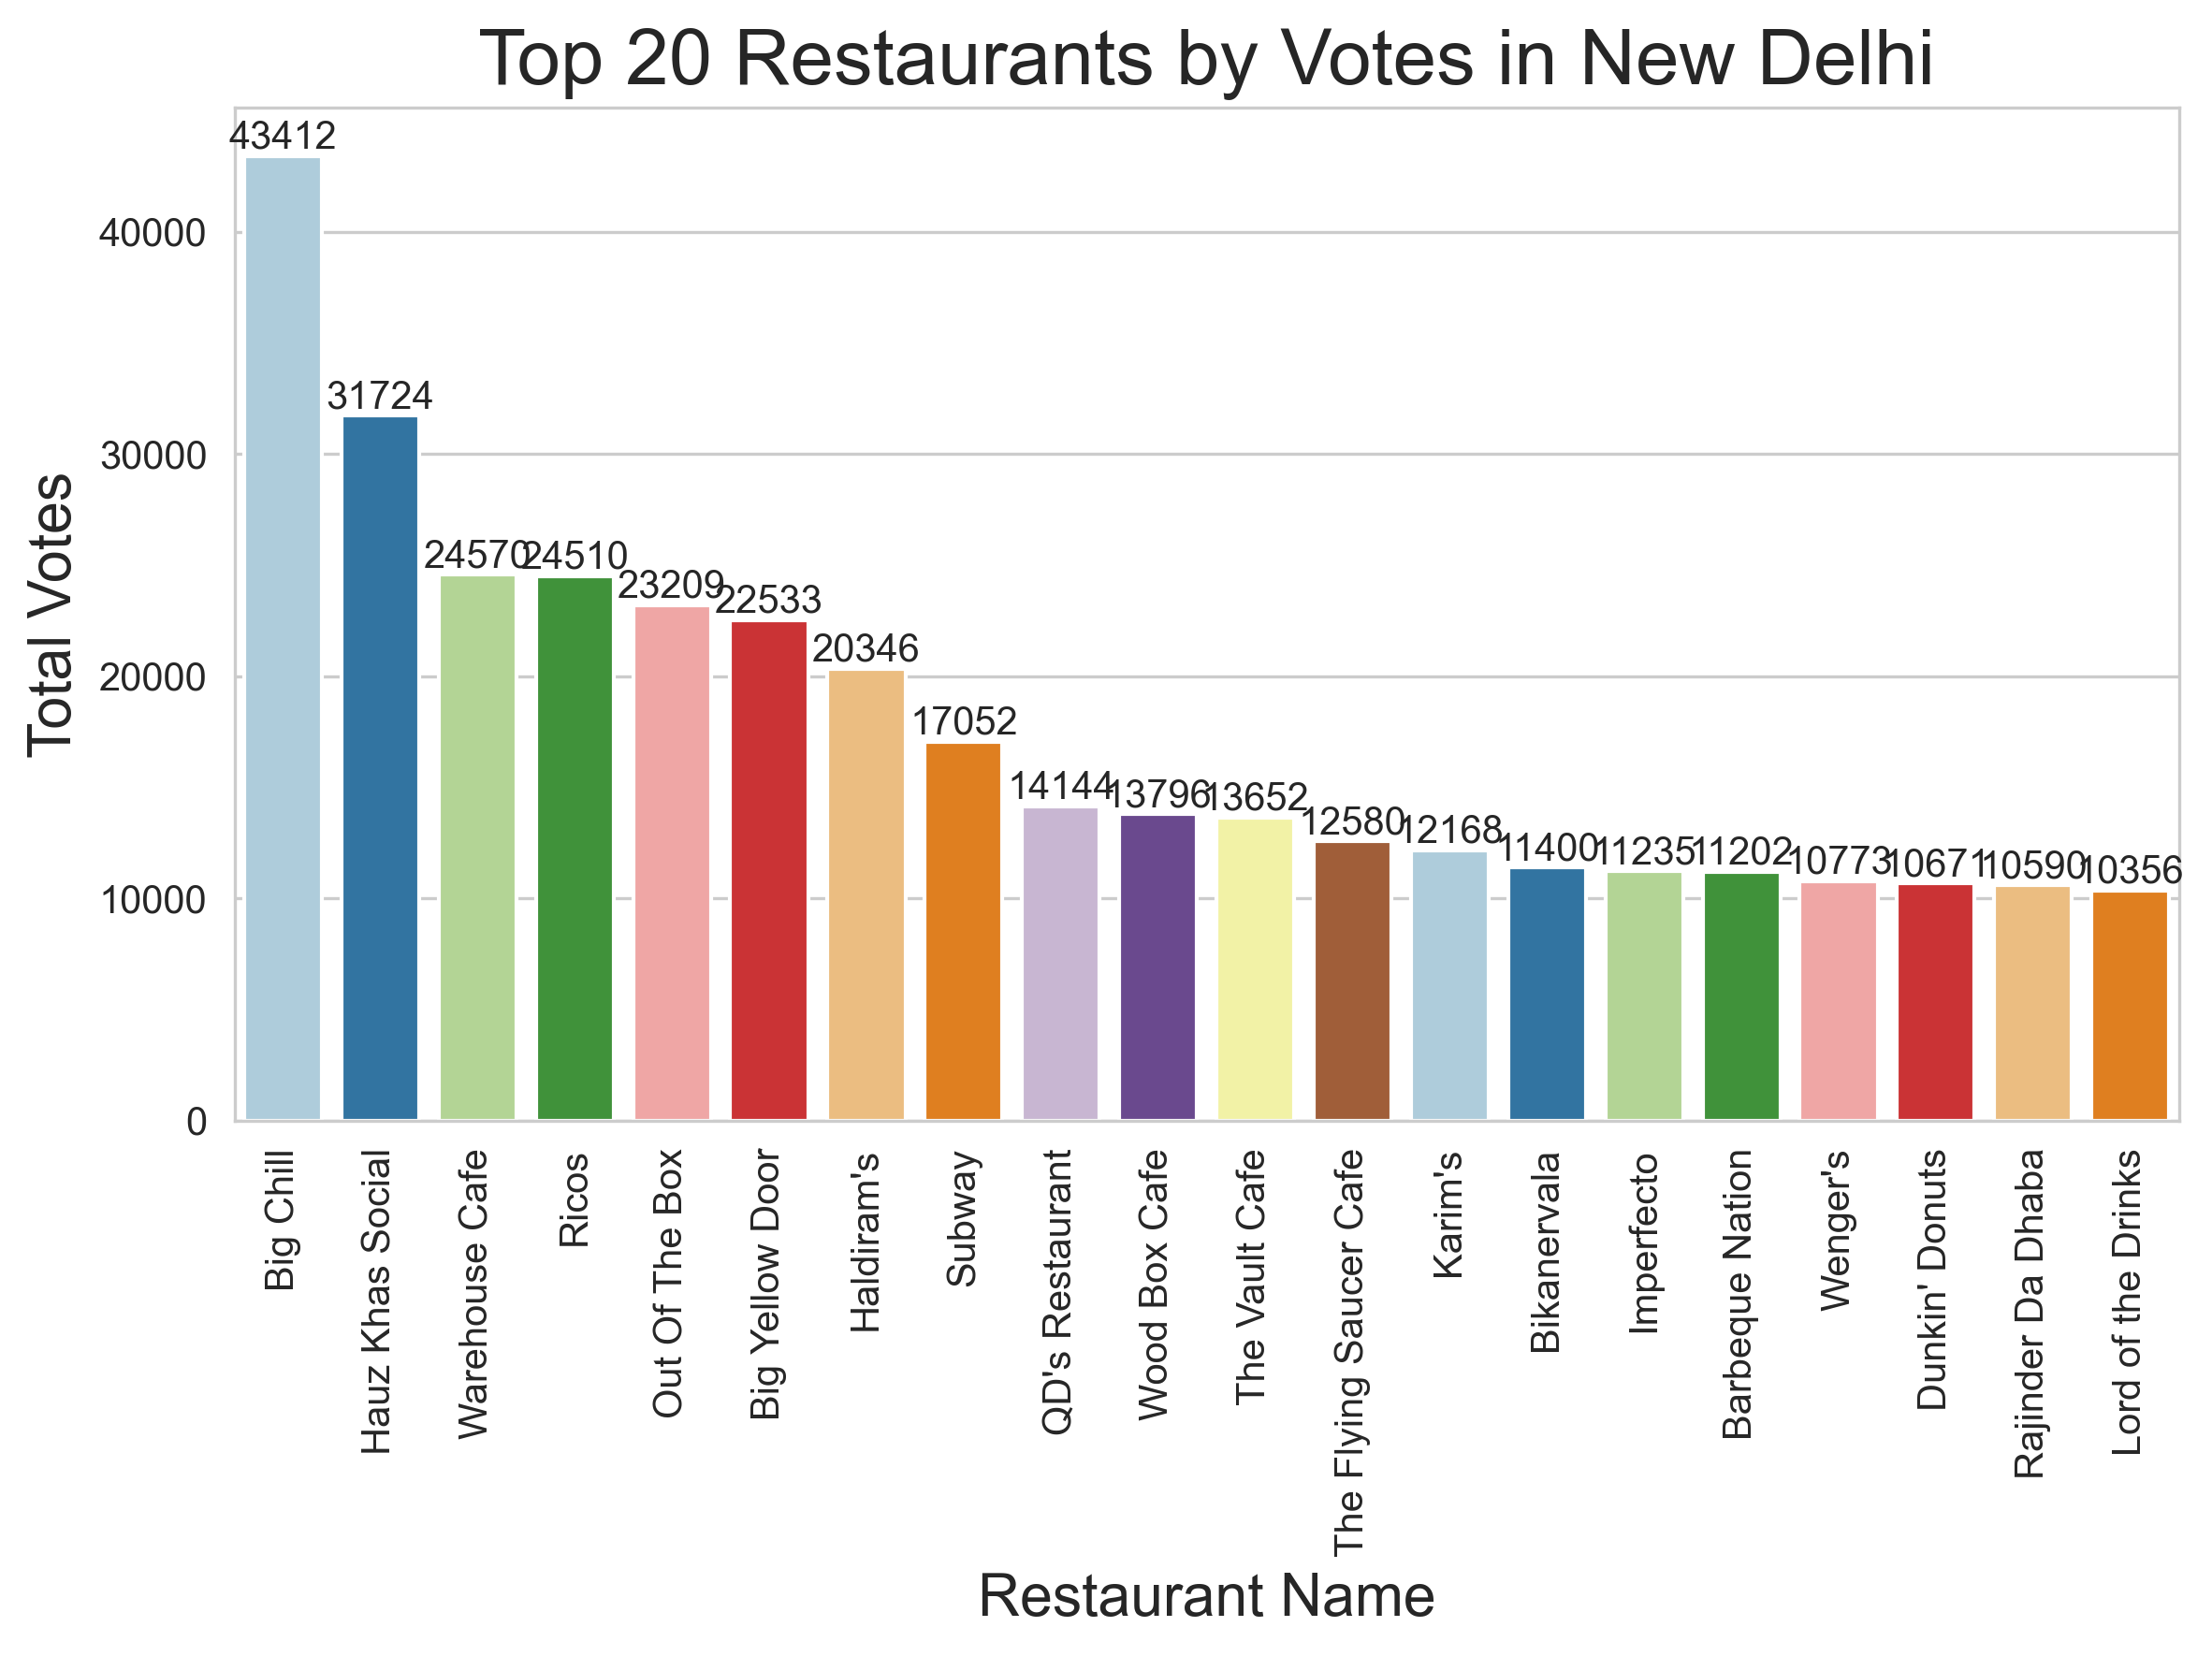

In [19]:
top_votes = delhi_df.groupby('Restaurant Name')['Votes'].sum().sort_values(ascending=False)[:20]
print(top_votes)
plt.figure(figsize=(8,6))
ax = sns.barplot(x=top_votes.index, y=top_votes.values, palette='Paired')
for i in ax.patches:
    ax.annotate(i.get_height().astype(int), (i.get_x() + i.get_width()/2, i.get_height()),
                ha='center', va='bottom')

plt.title('Top 20 Restaurants by Votes in New Delhi', fontsize=20)
plt.xlabel('Restaurant Name', fontsize=15)
plt.ylabel('Total Votes', fontsize=15)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('PNG/Top 20 Restaurants by Votes in New Delhi.png',dpi=500)
plt.show()

## Concentration of customer demand (votes)

In [20]:
# Sort by total restaurant votes
votes_by_restaurant = delhi_df.groupby('Restaurant Name')['Votes'].sum().sort_values(ascending=False)
n = len(votes_by_restaurant)
total_votes = votes_by_restaurant.sum()

# Top 5%
top_5pct_count = int(n * 0.05)
top_5pct_votes = votes_by_restaurant.iloc[:top_5pct_count].sum()
top_5pct_ratio = top_5pct_votes / total_votes * 100

# Top 20%
top_20pct_count = int(n * 0.20)
top_20pct_votes = votes_by_restaurant.iloc[:top_20pct_count].sum()
top_20pct_ratio = top_20pct_votes / total_votes * 100

# Bottom 50%
bottom_50pct_count = int(n * 0.50)
bottom_50pct_votes = votes_by_restaurant.iloc[-bottom_50pct_count:].sum()
bottom_50pct_ratio = bottom_50pct_votes / total_votes * 100

print(f"The top 5% of restaurants account for approximately {top_5pct_ratio:.2f}% of the total votes.")
print(f"The top 20% of restaurants account for approximately {top_20pct_ratio:.2f}% of the total votes.")
print(f"The bottom 50% of restaurants account for only about {bottom_50pct_ratio:.2f}% of the total votes.")

The top 5% of restaurants account for approximately 58.47% of the total votes.
The top 20% of restaurants account for approximately 86.48% of the total votes.
The bottom 50% of restaurants account for only about 2.69% of the total votes.


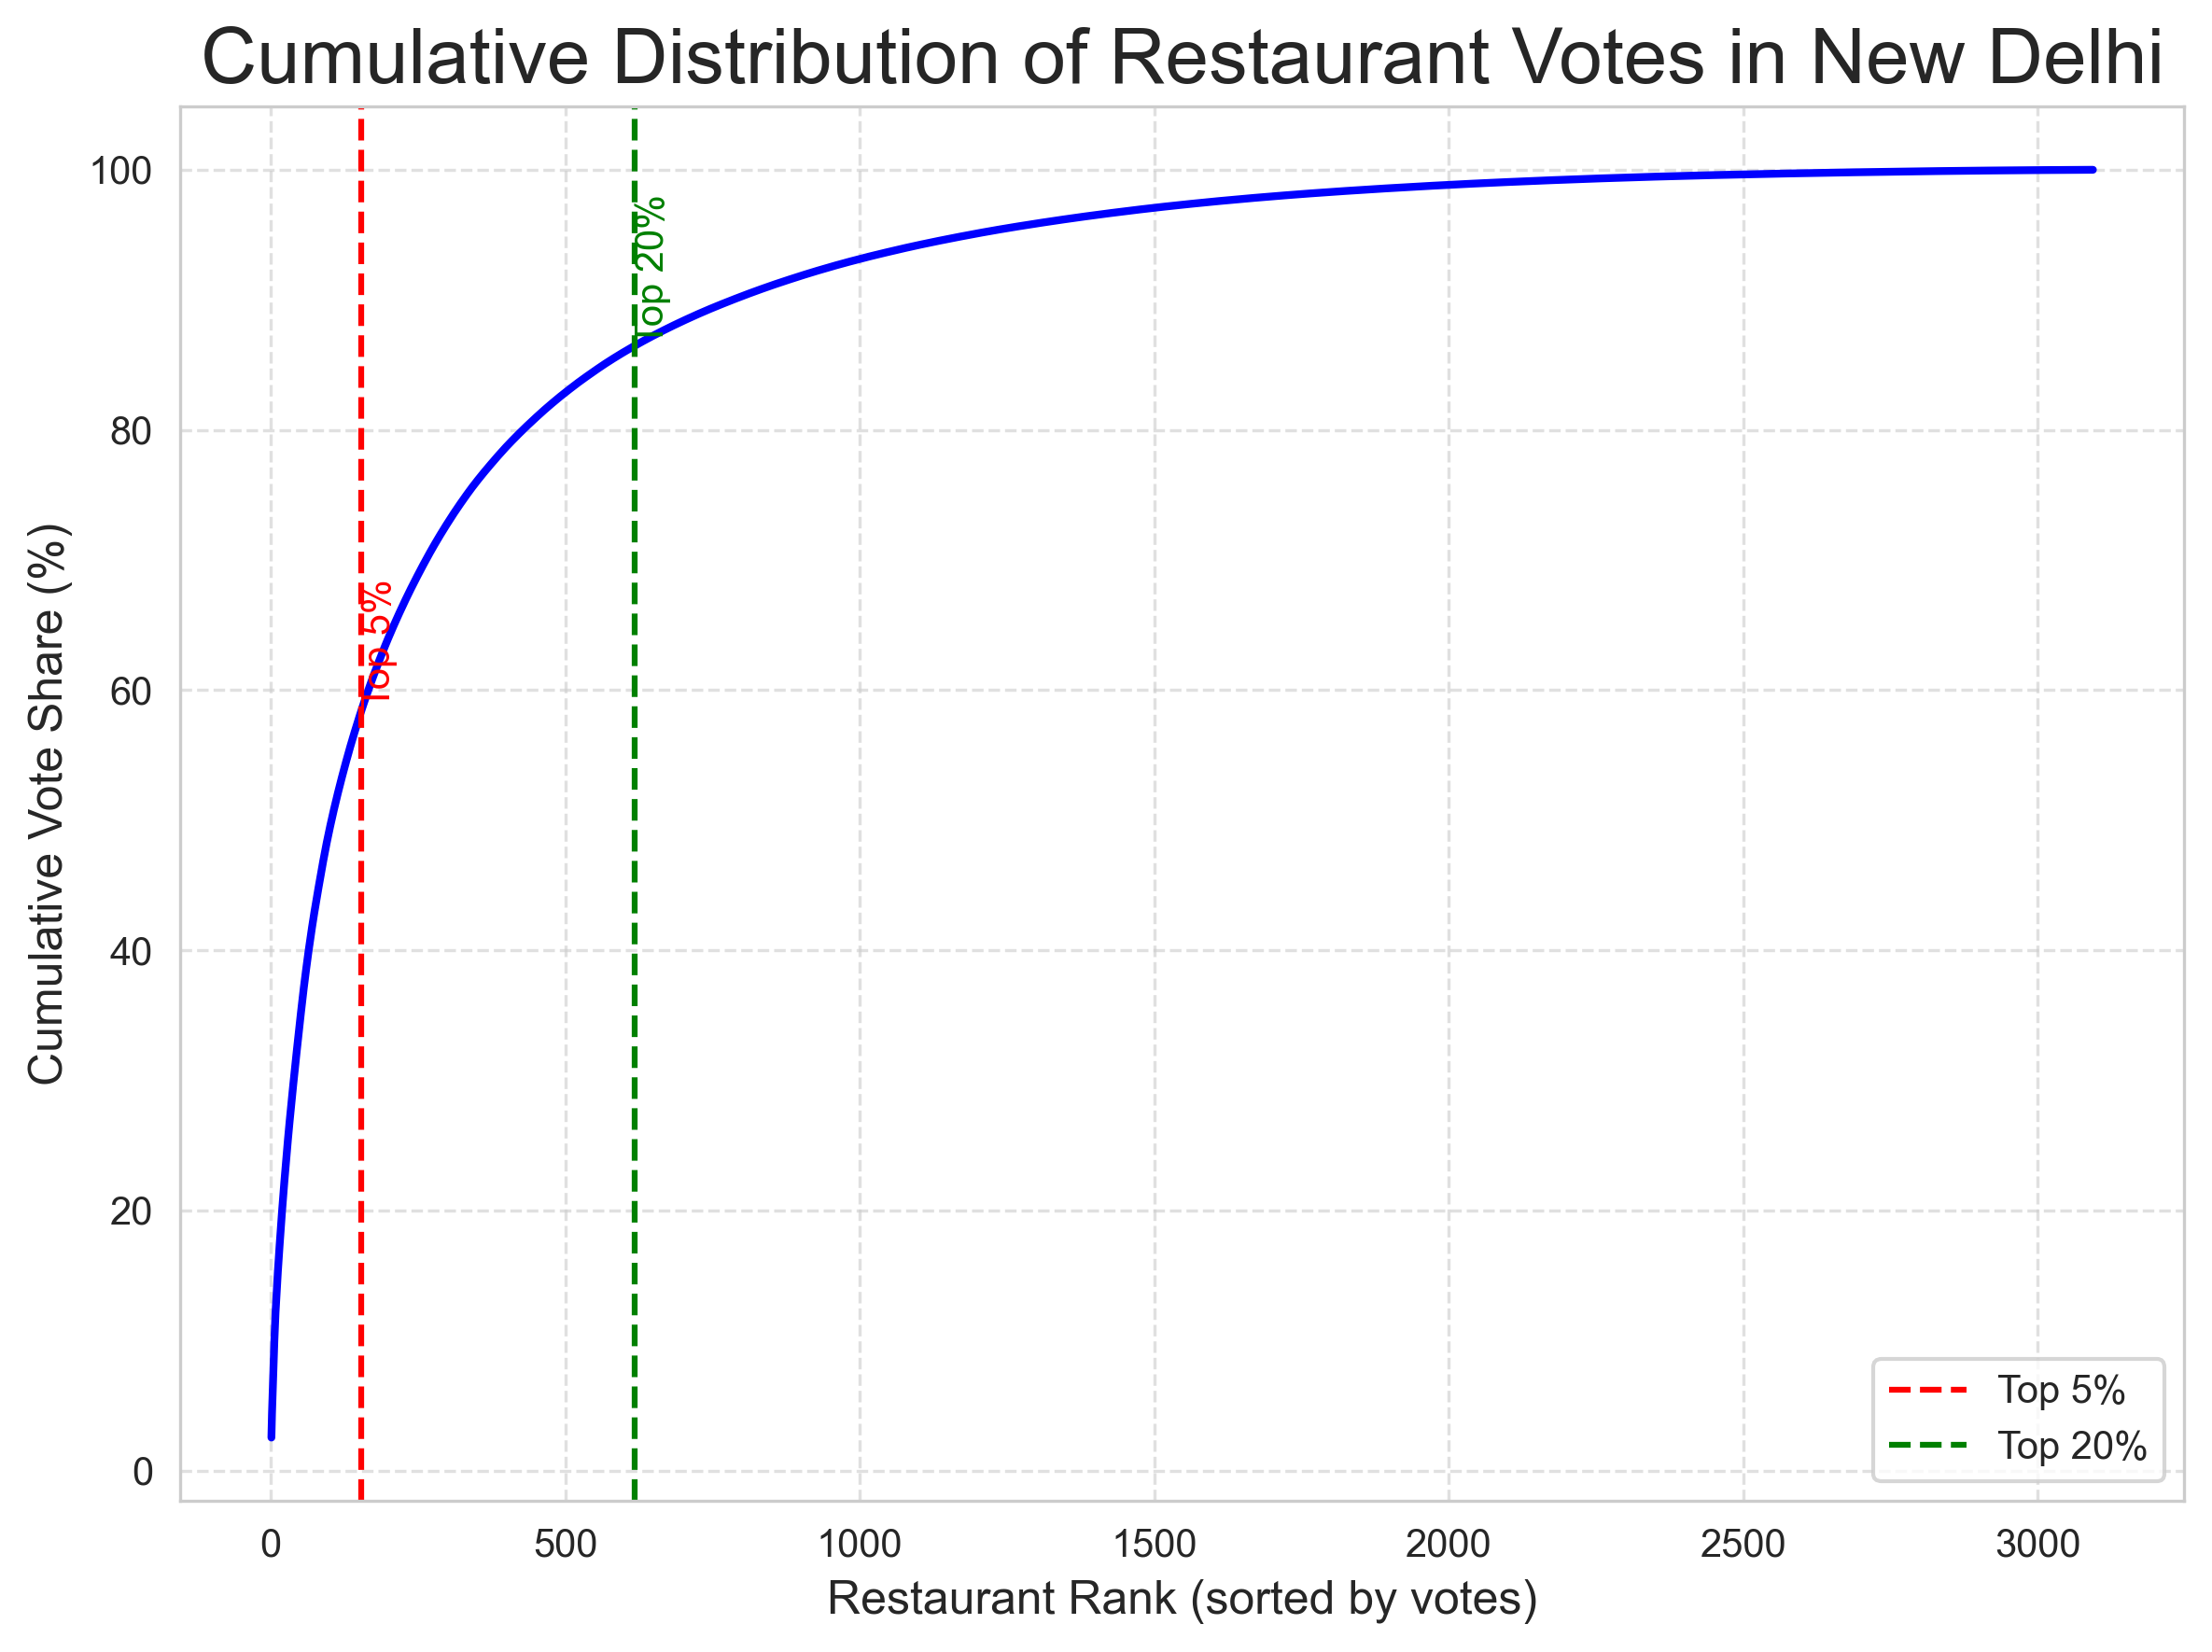

In [21]:
votes_sorted = votes_by_restaurant.values

# Calculate cumulative vote percentage
cumulative_votes = np.cumsum(votes_sorted)
cumulative_percent = cumulative_votes / cumulative_votes[-1] * 100

# X-axis: Restaurant Rank
ranks = np.arange(1, len(votes_sorted) + 1)

plt.figure(figsize=(8, 6))
plt.plot(ranks, cumulative_percent, color='blue', linewidth=2)

# Mark the Top 5% and Top 20%
n = len(votes_sorted)
top_5_idx = int(n * 0.05)
top_20_idx = int(n * 0.20)

plt.axvline(x=top_5_idx, color='red', linestyle='--', label='Top 5%')
plt.axvline(x=top_20_idx, color='green', linestyle='--', label='Top 20%')

# Add text annotations
plt.text(top_5_idx, cumulative_percent[top_5_idx], 'Top 5%', color='red', rotation=90, va='bottom')
plt.text(top_20_idx, cumulative_percent[top_20_idx], 'Top 20%', color='green', rotation=90, va='bottom')

plt.title('Cumulative Distribution of Restaurant Votes in New Delhi', fontsize=20)
plt.xlabel('Restaurant Rank (sorted by votes)', fontsize=12)
plt.ylabel('Cumulative Vote Share (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('PNG/Cumulative Distribution of Restaurant Votes in New Delhi.png',dpi=500)
plt.show()